# Overview
- batch ごとでモデル作ってみる

# Const

In [2]:
NB = '004'
isSmallSet = False
LENGTH = 1000

PATH_TRAIN = './../data/input/train.csv'
PATH_TEST = './../data/input/test.csv'
PATH_SMPLE_SUB = './../data/input/sample_submission.csv'
DIR_OUTPUT = './../data/output/'
cp = ['#f8b195', '#f67280', '#c06c84', '#6c5b7b', '#355c7d']
sr = 10*10**3  # 10 kHz

# Import everything I need :)

In [3]:
import warnings
warnings.filterwarnings('ignore')
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fastprogress import progress_bar
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import f1_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from dtreeviz.trees import dtreeviz

# My function

In [4]:
def f1_macro(true, pred):
    return f1_score(true, pred, average='macro')

def get_df_batch(df, batch):
    idxs = df['batch'] == batch
    assert any(idxs), 'そのようなbatchはありません'
    return df[idxs]
    
def get_signal_mv(df, n=3001):
    signal_mv = np.zeros(len(df))
    for bt in progress_bar(df['batch'].unique()):
        idxs = df['batch'] == bt
        _signal_mv = df['signal'][idxs].rolling(n, center=True).mean().interpolate('spline', order=5, limit_direction='both').values
        signal_mv[idxs] = _signal_mv
    return signal_mv

class permutation_importance():
    def __init__(self, model, metric):
        self.is_computed = False
        self.n_feat = 0
        self.base_score = 0
        self.model = model
        self.metric = metric
        self.df_result = []
    
    def compute(self, X_valid, y_valid):
        self.n_feat = len(X_valid.columns)
        if self.metric == 'auc':
            y_valid_score = self.model.predict_proba(X_valid)[:, 1]
            fpr, tpr, thresholds = roc_curve(y_valid, y_valid_score)
            self.base_score = auc(fpr, tpr)
        else:
            pred = np.round(self.model.predict(X_valid)).astype('int8')
            self.base_score = self.metric(y_valid, pred)
        self.df_result = pd.DataFrame({'feat': X_valid.columns, 
                                       'score': np.zeros(self.n_feat),
                                       'score_diff': np.zeros(self.n_feat)})
        
        # predict
        for i, col in enumerate(X_valid.columns):
            df_perm = X_valid.copy()
            np.random.seed(1)
            df_perm[col] = np.random.permutation(df_perm[col])
            y_valid_pred = self.model.predict(df_perm)
            if self.metric == 'auc':
                y_valid_score = self.model.predict_proba(df_perm)[:, 1]
                fpr, tpr, thresholds = roc_curve(y_valid, y_valid_score)
                score = auc(fpr, tpr)
            else:
                score = self.metric(y_valid, np.round(y_valid_pred).astype('int8'))
            self.df_result['score'][self.df_result['feat']==col] = score
            self.df_result['score_diff'][self.df_result['feat']==col] = self.base_score - score
        self.is_computed = True
    
    def get_negative_feature(self):
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        idx = self.df_result['score_diff'] < 0
        return self.df_result.loc[idx, 'feat'].values.tolist()
        
    def get_positive_feature(self):
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        idx = self.df_result['score_diff'] > 0
        return self.df_result.loc[idx, 'feat'].values.tolist()
    
    def show_permutation_importance(self, score_type='loss'):
        '''score_type = 'loss' or 'accuracy'  '''
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        if score_type=='loss':
            ascending = True
        elif score_type=='accuracy':
            ascending = False
        else:
            ascending = ''
        
#         plt.figure(figsize=(15, int(0.25*self.n_feat)))
        sns.barplot(x="score_diff", y="feat", data=self.df_result.sort_values(by="score_diff", ascending=ascending))
        plt.title('base_score - permutation_score')

# Preparation

setting

In [5]:
sns.set()

<br>

load dataset

In [6]:
df_tr = pd.read_csv(PATH_TRAIN)
df_te = pd.read_csv(PATH_TEST)

<br>

処理のしやすさのために、バッチ番号を振る

In [7]:
batch_list = []
for n in range(10):
    batchs = np.ones(500000)*n
    batch_list.append(batchs.astype(int))
batch_list = np.hstack(batch_list)
df_tr['batch'] = batch_list

batch_list = []
for n in range(4):
    batchs = np.ones(500000)*n
    batch_list.append(batchs.astype(int))
batch_list = np.hstack(batch_list)
df_te['batch'] = batch_list

<br>

smallset?

In [8]:
if isSmallSet:
    print('small set mode')
    # train
    batchs = df_tr['batch'].values
    dfs = []
    for i_bt, bt in enumerate(df_tr['batch'].unique()):
        idxs = batchs == bt
        _df = df_tr[idxs][:LENGTH].copy()
        dfs.append(_df)
    df_tr = pd.concat(dfs).reset_index(drop=True)
    
    # test
    batchs = df_te['batch'].values
    dfs = []
    for i_bt, bt in enumerate(df_te['batch'].unique()):
        idxs = batchs == bt
        _df = df_te[idxs][:LENGTH].copy()
        dfs.append(_df)
    df_te = pd.concat(dfs).reset_index(drop=True)

# Experiments(decision tree)
- バッチごとで学習してみる

移動平均を計算

In [9]:
df_tr['signal_mv'] = get_signal_mv(df_tr, n=3001)
df_te['signal_mv'] = get_signal_mv(df_te, n=3001)

<br>

学習

::batch = 0::
feat: Index(['signal', 'signal_mv'], dtype='object')
[signal] f1_macro: 0.9852


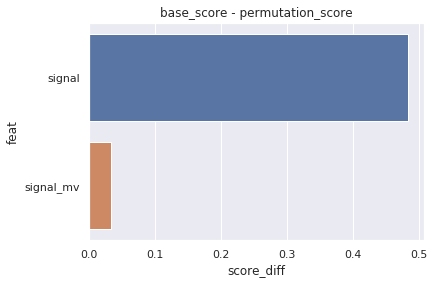


::batch = 1::
feat: Index(['signal', 'signal_mv'], dtype='object')
[signal] f1_macro: 0.9775


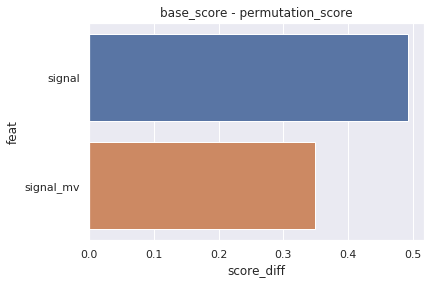


::batch = 2::
feat: Index(['signal', 'signal_mv'], dtype='object')
[signal] f1_macro: 0.9894


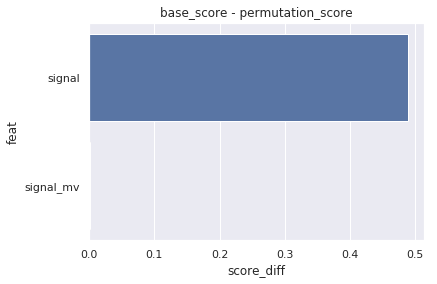


::batch = 3::
feat: Index(['signal', 'signal_mv'], dtype='object')
[signal] f1_macro: 0.9691


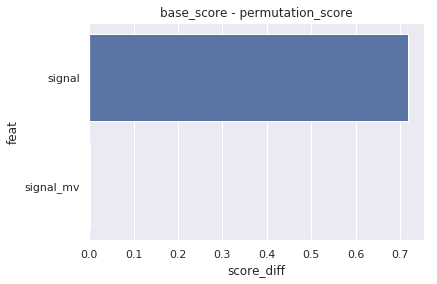


::batch = 4::
feat: Index(['signal', 'signal_mv'], dtype='object')
[signal] f1_macro: 0.8007


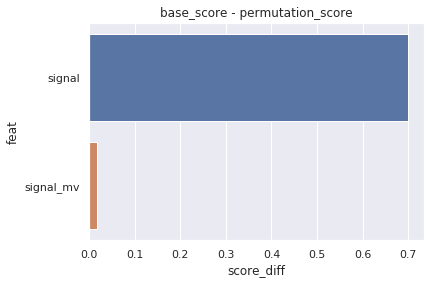


::batch = 5::
feat: Index(['signal', 'signal_mv'], dtype='object')
[signal] f1_macro: 0.9462


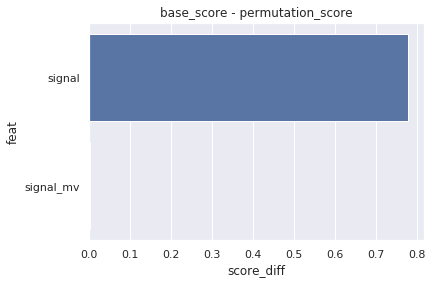


::batch = 6::
feat: Index(['signal', 'signal_mv'], dtype='object')
[signal] f1_macro: 0.9840


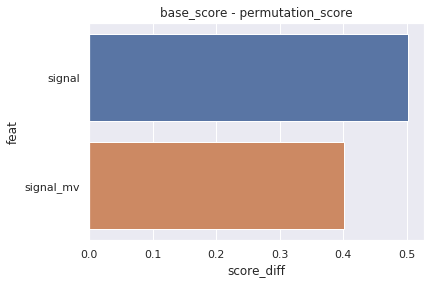


::batch = 7::
feat: Index(['signal', 'signal_mv'], dtype='object')
[signal] f1_macro: 0.8838


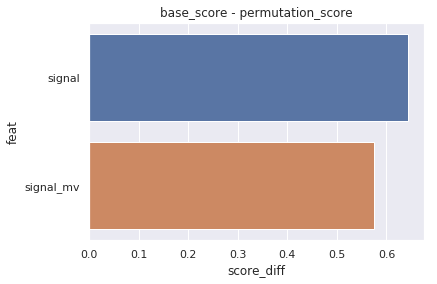


::batch = 8::
feat: Index(['signal', 'signal_mv'], dtype='object')
[signal] f1_macro: 0.9038


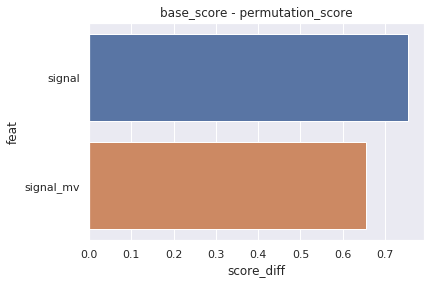


::batch = 9::
feat: Index(['signal', 'signal_mv'], dtype='object')
[signal] f1_macro: 0.7150


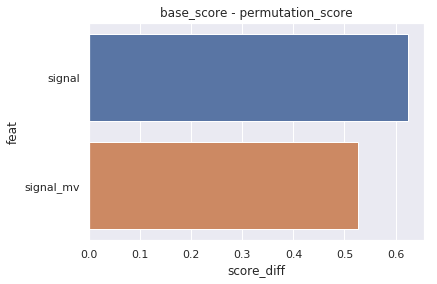


CPU times: user 20.1 s, sys: 2.14 s, total: 22.3 s
Wall time: 18.2 s


In [10]:
%%time
test_pred_rounds = []
test_preds = []
for bt in df_tr['batch'].unique():
    print(f'::batch = {bt}::')
    df_tr_batch = get_df_batch(df_tr, bt)
    
    # train
    X_train, X_valid, y_train, y_valid = train_test_split(df_tr_batch[['signal', 'signal_mv']], df_tr_batch['open_channels'], test_size=0.33, random_state=42)
    model = DecisionTreeRegressor()
    model.fit(X_train, y_train)
    
    # pred
    y_valid_pred = model.predict(X_valid)
    y_valid_pred_round = np.round(y_valid_pred).astype('int8')
    test_pred = model.predict(df_te[['signal', 'signal_mv']])
    test_pred_round = np.round(test_pred).astype('int8')
    test_preds.append(test_pred)
    test_pred_rounds.append(test_pred_round)
    
    # result
    print(f'feat: {X_train.columns}')
    print(f'[signal] f1_macro: {f1_score(y_valid, y_valid_pred_round, average="macro"):.4f}')
    pi = permutation_importance(model, f1_macro) # model と metric を渡す
    pi.compute(X_valid, y_valid)
    pi.show_permutation_importance(score_type='accuracy')  # loss or accuracy
    plt.show()
    print('==============================================================\n')

> 決定木でも十分な結果出るな  
> signalがアーチ状になっている、6,7,8,9のbatchでsingnal_mvのpiが大きくなっていることがよくわかる

<br>

batchごとで作ったモデルが予測したtestデータの分布を確認

In [11]:
dfs = []
for bt in df_tr['batch'].unique():
    _df = pd.DataFrame()
    _df['open_channels'] = test_pred_rounds[bt]
    _df['batch'] = bt
    dfs.append(_df)
df_concat = pd.concat(dfs, axis=0)

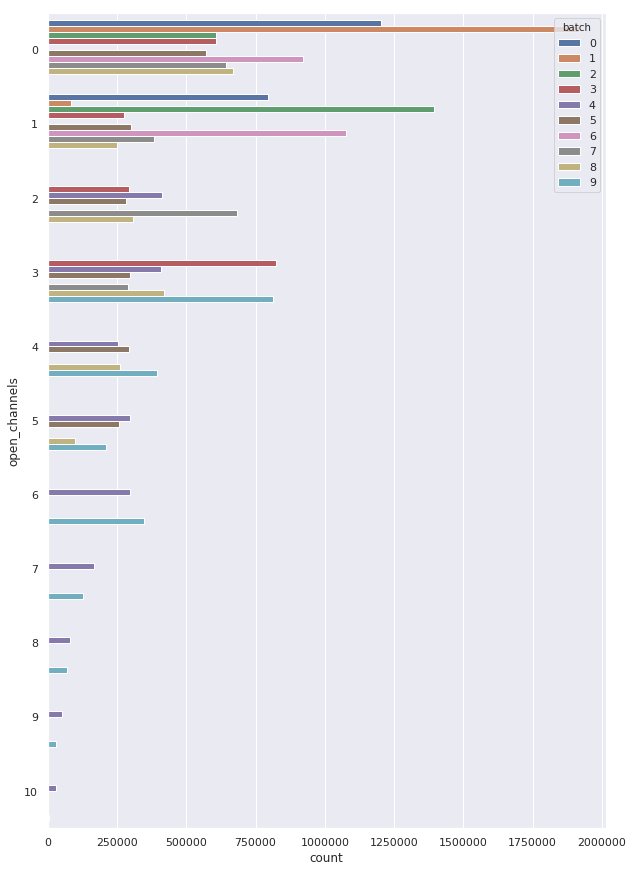

In [12]:
plt.figure(figsize=(10, 15))
sns.countplot(y='open_channels', hue='batch', data=df_concat)

> batch 4, 9以外は、och6以上を表現できていない。  
> 決定木だから外装できないので、当たり前か。

# save

In [44]:
test_preds = np.array(test_preds)
test_pred = np.mean(test_preds, axis=0)
test_pred_round = np.round(test_pred).astype('int8')

In [45]:
save_path = f'{DIR_OUTPUT}submission_nb{NB}_cv_none.csv'
sub = pd.read_csv(PATH_SMPLE_SUB)
sub['open_channels'] = test_pred_round
print(f'save path: {save_path}')

save path: ./../data/output/submission_nb004_cv_none.csv


In [46]:
sub.to_csv(save_path, index=False, float_format='%.4f')